# Offline FlexDTW 3D

This notebook provides wrapper functions for calling the [ISA (Iterative Subtractive Alignment) algorithm](https://archives.ismir.net/ismir2021/paper/000101.pdf).  Running this algorithm requires installing some other software, which is described below.  This notebook implements the `offline_processing()` and `online_processing()` functions, which will be imported and run in `02_RunExperiment.ipynb`.

## Offline Processing

The offline processing is the same as in the simple offline DTW system.  In the offline processing stage, three things are computed and stored in the `cache/` folder:
- chroma features for the orchestra recording
- chroma features for the full mix recording
- predicted DTW alignment between the orchestra and full mix recordings



In [3]:
import numpy as np
import pandas as pd
import import_ipynb
import system_utils
import align_tools
import sonify_tools
import os
import os.path
import subprocess
import librosa as lb
from shutil import which
from hmc_mir.align import isa
import matplotlib.pyplot as plt
from numba import jit, njit, prange
import k3d

In [4]:
def offline_processing(scenario_dir, cache_dir, hop_length=2048, downsample=10):
    '''
    Carries out the same offline processing steps as the simple offline DTW system.
    
    Args:
        scenario_dir: The scenario directory to process
        cache_dir: The location of the cache directory
        hop_length: The hop length in samples used when computing chroma features
        downsample: The downsampling factor used when computing chroma_sens features
    
    This function will store the computed chroma features and estimated alignment in the cache folder.
    '''
    # setup
    system_utils.verify_scenario_dir(scenario_dir)
    if os.path.exists(cache_dir):
        # print(f'{cache_dir} has already been processed.  Skipping.')
        pass
    else:
        # setup
        os.makedirs(cache_dir)

        o_file = f'{scenario_dir}/o.wav'
        y_o, sr = lb.core.load(o_file)
        F_o = lb.feature.chroma_cens(y=y_o, sr=sr, hop_length=hop_length)[:,::downsample]

        po_file = f'{scenario_dir}/po.wav'
        y_po, sr = lb.core.load(po_file)
        F_po = lb.feature.chroma_cens(y=y_po, sr=sr, hop_length=hop_length)[:,::downsample]

        np.save(f'{cache_dir}/po_cqt.npy', F_po)
        np.save(f'{cache_dir}/o_cqt.npy', F_o)

    return

In [5]:
def verify_cache_dir(indir):
    '''
    Verifies that the specified cache directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/po_cqt.npy'), f'missing {indir}/po_cqt.npy'
    assert os.path.exists(f'{indir}/o_cqt.npy'), f'missing {indir}/o_cqt.npy'

## Online Processing

### Wrapper Implementation

In [6]:
def online_processing(
    scenario_dir,
    out_dir,
    cache_dir,
    hop_length=2048,
    downsample=10,
    steps=np.array([
        [1,1,1],
        [2,1,1],
        [1,2,1],
        [1,1,2],
        [2,2,1],
        [2,1,2],
        [1,2,2],
    ]),
    weights=np.array([3,4,4,4,5,5,5])
):
    '''
    Carries out `online' processing using the ISA algorithm.
    
    Args:
        scenario_dir: The scenario directory to process
        out_dir: The directory to put results, intermediate files, and logging info
        cache_dir: The cache directory
        hop_length: The hop length in samples used when computing cqt features
        downsample: The downsampling factor used when computing chroma_sens features

    This function will compute and save the predicted alignment in the output directory in a file hyp.npy
    '''
    
    # verify & setup
    system_utils.verify_scenario_dir(scenario_dir)
    verify_cache_dir(cache_dir)
    assert not os.path.exists(out_dir), f'Output directory {out_dir} already exists.'
    os.makedirs(out_dir)

    p_file = f'{scenario_dir}/p.wav'
    y, sr = lb.core.load(p_file)

    F_p = lb.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length)[:,::downsample]
    F_po = np.load(f'{cache_dir}/po_cqt.npy') # full mix features
    F_o = np.load(f'{cache_dir}/o_cqt.npy') # orchestra

    hop_sec = downsample * hop_length / sr

    # compute the alignment
    best_cost, path, debug = flexdtw(F_p, F_o, F_po, steps, weights, buffer = 20)

    wp_AC = np.vstack((path[0],path[1]))
    np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)
    
    return

In [7]:
def verify_hyp_dir(indir):
    '''
    Verifies that the specified scenario hypothesis directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/hyp.npy'), f'{indir} is missing the required files, please re run the online processing'

# Example

Here is an example of how to call the offline and online processing functions on a scenario directory.

In [55]:
# scenario_dir = 'scenarios/s105'
# out_dir = 'experiments/flexDTW/s105'
# cache_dir = 'experiments/flexDTW/cache/beeth1_mov1_O1_PO1'
# hop_length = 2048
# downsample = 10

In [60]:
# orch_start_sec, orch_end_sec = system_utils.get_orchestra_start_end_times(scenario_dir)
# orch_start_frm = int(np.round(orch_start_sec * sr / hop_length))
# orch_end_frm = int(np.round(orch_end_sec * sr / hop_length)) + 1

# o_file = f'{scenario_dir}/o.wav'
# y_o, sr = lb.core.load(o_file)
# # y_o = y_o[int(orch_start_sec*sr):int(orch_end_sec*sr)]
# F_o = lb.feature.chroma_cens(y=y_o, sr=sr, hop_length=hop_length)
# # F_o = F_o[:,orch_start_frm:orch_end_frm]
# F_o = F_o[:,::downsample]

# po_file = f'{scenario_dir}/po.wav'
# y_po, sr = lb.core.load(po_file)
# y_po = y_po[int(orch_start_sec*sr):]
# F_po = lb.feature.chroma_cens(y=y_po, sr=sr, hop_length=hop_length)[:,::downsample]

# np.save(f'{cache_dir}/po_cqt.npy', F_po)
# np.save(f'{cache_dir}/o_cqt.npy', F_o)

In [71]:
# p_file = f'{scenario_dir}/p.wav'
# y, sr = lb.core.load(p_file)

# F_p = lb.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length)[:,::downsample]
# F_po = np.load(f'{cache_dir}/po_cqt.npy') # full mix features
# F_o = np.load(f'{cache_dir}/o_cqt.npy') # orchestra

# hop_sec = downsample * hop_length / sr

In [72]:
# F_p.shape, F_po.shape, F_o.shape

((12, 131), (12, 997), (12, 913))

In [73]:
@njit(parallel=True)
def calculate_cost_tensor(x, y, z):
    '''
    Calculates the cost tensor for the given piano, orchestra, and piano-orchestra features.
    
    Args:
        x: submix features
        y: submix features
        z: full mix features
    '''
    x = x.T
    y = y.T
    z = z.T
    cost_tensor = np.zeros((x.shape[0], y.shape[0], z.shape[0]))
    for i in prange(x.shape[0]):
        for j in prange(y.shape[0]):
            for k in prange(z.shape[0]):
                cost_tensor[i, j, k] = 1 - (np.dot(z[k,:], x[i,:] + y[j,:]) / (np.linalg.norm(z[k,:]) * np.linalg.norm(x[i,:] + y[j,:])))
    return cost_tensor

In [74]:
@jit(nopython=True)
def backtrace_flexdtw(D, B, steps, rstart, cstart, tstart):
    '''
    Backtraces through the cumulative cost matrix D starting from a specified location.
    
    Arguments:
    D: cumulative cost matrix
    B: backtrace matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    rstart: the row index to start backtracking from
    cstart: the column index to start backtracking from
    
    Outputs
    path: a python list of (row, col) coordinates for the optimal path.
    '''
    pos = (rstart, cstart, tstart)
    path = []
    path.append(pos)
    while(pos[0] != 0 and pos[1] != 0 and pos[2] != 0):
        (row, col, tube) = pos
        stepidx = B[row, col, tube]
        (rstep, cstep, tstep) = steps[stepidx]
        pos = (row-rstep, col-cstep, tube-tstep)
        path.append(pos)
    
    return path

In [75]:
@jit(nopython=True)
def find_best_endpoint(D, P, buffer):
    '''
    Determines the best location to begin backtracking from by comparing the average path cost
    per manhattan block.
    
    Inputs
    D: the cumulative cost matrix
    P: the matrix specifying the starting location of the alignment path
    buffer: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path.
    
    Outputs
    best_cost: the best average path cost per manhattan block
    best_r: the row index of the best endpoint
    best_c: the column index of the best endpoint
    debug: debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions
    '''
    
    # consider the top corner 3 faces as candidates
    candidates = []
    for i in range(buffer, D.shape[0]):
        for j in range(buffer, D.shape[1]):
            candidates.append((i, j, D.shape[2]-1))

    for j in range(buffer, D.shape[1]):
        for k in range(buffer, D.shape[2]):
            candidates.append((D.shape[0]-1, j, k))

    for i in range(buffer, D.shape[0]):
        for k in range(buffer, D.shape[2]):
            candidates.append((i, D.shape[1]-1, k))
    
    best_cost = np.inf
    best_r, best_c, best_t = -1, -1, -1
    # debug = []
    debug = np.zeros_like(D)
    
    for i, (r,c,t) in enumerate(candidates):
                
        # get alignment start location
        rstart, cstart, tstart = P[r,c,t]
            
        # calculate average cost per manhattan block
        mdist = (r - rstart) + (c - cstart) + (t - tstart)# manhattan distance
        avg_cost_per_mb = D[r,c,t] / mdist
        
        # keep best
        if avg_cost_per_mb < best_cost:
            best_cost = avg_cost_per_mb
            best_r, best_c, best_t = r, c, t
            
        # debugging info
        # TODO: updated this for 3D-FlexDTW
        # if r == D.shape[0]-1:
        #     debug.append((c-D.shape[1]+1, avg_cost_per_mb, r, c))
        # else:
        #     debug.append((D.shape[0]-1-r, avg_cost_per_mb, r, c))
        debug[r,c,t] = avg_cost_per_mb
    
    return best_cost, best_r, best_c, best_t, debug

In [76]:
@jit(nopython=True)
def flexdtw(x, y, z, steps, weights, buffer = 1):
    C = calculate_cost_tensor(x, y, z)
    
    # Run FlexDTW on the cost tensor
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)
    P = np.zeros((C.shape[0], C.shape[1], C.shape[2], 3), dtype=np.int32)

    # D[0, :, :] = C[0, :, :]
    # D[:, 0, :] = C[:, 0, :]
    # D[:, :, 0] = C[:, :, 0]
    # D[0, :, :] = np.inf
    # D[:, 0, :] = np.inf
    # D[:, :, 0] = np.inf
    D[0,0,0] = C[0,0,0]

    # DP
    for row in range(1,C.shape[0]):
        for col in range(1, C.shape[1]):
            for tube in range (1, C.shape[2]):
                mincost = np.inf
                minidx = -1
                bestrprev = -1
                bestcprev = -1
                besttprev = -1
                for stepidx, step in enumerate(steps):
                    (rstep, cstep, tstep) = step
                    prevrow = row - rstep
                    prevcol = col - cstep
                    prevtube = tube - tstep
                    if prevrow >= 0 and prevcol >= 0 and prevtube >= 0:
                        
                        # calculate avg cost per manhattan block
                        pathcost = D[prevrow, prevcol, prevtube] + C[row, col, tube] * weights[stepidx]
                        mdist = row + col + tube - np.sum(P[prevrow, prevcol, prevtube])
                        cost_per_mb = pathcost / mdist
                        
                        # select best transition based on avg cost per manhattan block
                        if cost_per_mb < mincost:
                            mincost = cost_per_mb
                            minidx = stepidx
                            bestrprev = prevrow
                            bestcprev = prevcol
                            besttprev = prevtube
                            
                D[row, col, tube] = D[bestrprev, bestcprev, besttprev] + C[row, col, tube] * weights[minidx]
                B[row, col, tube] = minidx
                        
                if bestrprev == 0 or bestcprev == 0 or besttprev == 0:
                    P[row, col, tube][0] = bestrprev
                    P[row, col, tube][1] = bestcprev
                    P[row, col, tube][2] = besttprev
                else:
                    P[row, col, tube] = P[bestrprev, bestcprev, besttprev]

    best_cost, best_r, best_c, best_t, debug = find_best_endpoint(D, P, buffer)
    path = backtrace_flexdtw(D, B, steps, best_r, best_c, best_t)
    path.reverse()
    path = np.array(path)
    return best_cost, path.T, debug


In [78]:
# best_cost, path, debug = flexdtw(F_p, F_o, F_po, steps, weights, buffer = 20)

In [79]:
# path.T

array([[  0, 649, 625],
       [  1, 650, 626],
       [  3, 651, 628],
       [  5, 652, 629],
       [  6, 654, 630],
       [  7, 655, 631],
       [  9, 656, 633],
       [ 10, 658, 634],
       [ 11, 659, 635],
       [ 12, 661, 636],
       [ 13, 663, 638],
       [ 15, 665, 639],
       [ 17, 666, 641],
       [ 18, 667, 642],
       [ 20, 668, 643],
       [ 21, 669, 644],
       [ 22, 670, 645],
       [ 24, 671, 646],
       [ 26, 672, 648],
       [ 27, 674, 649],
       [ 28, 676, 651],
       [ 30, 678, 652],
       [ 31, 680, 654],
       [ 33, 681, 655],
       [ 34, 682, 656],
       [ 35, 684, 658],
       [ 36, 686, 660],
       [ 37, 687, 661],
       [ 39, 688, 662],
       [ 41, 689, 663],
       [ 42, 690, 664],
       [ 43, 691, 665],
       [ 44, 693, 666],
       [ 45, 695, 667],
       [ 47, 697, 668],
       [ 48, 699, 669],
       [ 49, 700, 670],
       [ 50, 702, 672],
       [ 51, 703, 673],
       [ 52, 704, 674],
       [ 54, 705, 676],
       [ 56, 706

In [80]:
# plt_line = k3d.line(path.T, width=0.1, color=0xff99cc)

# start_label = k3d.label('0,0,0', position=(0, 0, 0))
# # end_label = k3d.label('{}, {}, {}'.format(x.shape[1], y.shape[1], z.shape[1]), position=(x.shape[1], y.shape[1], z.shape[1]))
# end_label = k3d.label('{}, {}, {}'.format(F_p.shape[1], F_o.shape[1], F_po.shape[1]), position=(F_p.shape[1], F_o.shape[1], F_po.shape[1]))
# # end_label = k3d.label('{}, {}, {}'.format(context_size, context_size, context_size), position=(context_size, context_size, context_size))

# plot = k3d.plot()
# plot += plt_line
# plot += start_label
# plot += end_label
# plot.display()

/Users/kavidey/.pyenv/versions/anaconda3-2022.05/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

Output()

In [81]:
# cost_tensor =  calculate_cost_tensor(F_p, F_o, F_po)
# print(cost_tensor.shape)

(131, 913, 997)


In [82]:
# cost_tensor[0,0,0]

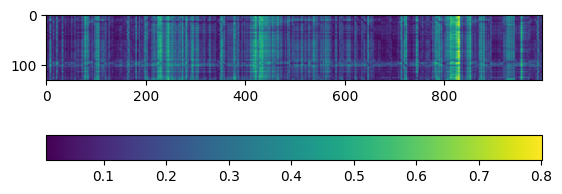

In [83]:
# plt.imshow(cost_tensor[:,0,:])
# plt.colorbar(orientation='horizontal')
# plt.show()

In [84]:
# plt_volume = k3d.volume(cost_tensor, bounds=[0, cost_tensor.shape[0], 0, cost_tensor.shape[1], 0, cost_tensor.shape[2]])

# plot = k3d.plot()
# plot += plt_volume
# plot.display()

/Users/kavidey/.pyenv/versions/anaconda3-2022.05/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/k3d/objects.py:1328: UserWarning: wrong dtype: float64 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

Output()

In [85]:
# vol = debug
# plt_volume = k3d.volume(vol, bounds=[0, vol.shape[0], 0, vol.shape[1], 0, vol.shape[2]])
# # plt_volume = k3d.volume(calculate_cost_tensor(F_p, F_o, F_po))

# plot = k3d.plot()
# plot += plt_volume
# plot.display()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

Output()

In [86]:
# # # infer piano-orchestra alignment
# wp_AC = np.vstack((path[0],path[1]))
# np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)

In [87]:
# np.vstack((path[0],path[1]))

array([[  0,   1,   3,   5,   6,   7,   9,  10,  11,  12,  13,  15,  17,
         18,  20,  21,  22,  24,  26,  27,  28,  30,  31,  33,  34,  35,
         36,  37,  39,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,
         52,  54,  56,  58,  59,  60,  61,  62,  64,  66,  67,  69,  70,
         72,  73,  75,  76,  77,  78,  80,  82,  84,  85,  86,  87,  88,
         90,  91,  93,  95,  97,  98,  99, 100, 102, 103, 104, 106, 107,
        108, 109, 111, 113, 115, 116, 117, 118, 120, 122, 124, 125, 126,
        128, 130],
       [649, 650, 651, 652, 654, 655, 656, 658, 659, 661, 663, 665, 666,
        667, 668, 669, 670, 671, 672, 674, 676, 678, 680, 681, 682, 684,
        686, 687, 688, 689, 690, 691, 693, 695, 697, 699, 700, 702, 703,
        704, 705, 706, 708, 710, 712, 713, 714, 715, 716, 718, 719, 720,
        721, 722, 723, 725, 727, 729, 730, 731, 732, 733, 735, 737, 739,
        740, 741, 742, 743, 744, 746, 747, 749, 750, 751, 752, 754, 755,
        757, 759, 760, 761, 762,

In [88]:
# system_utils.get_orchestra_query_boundaries(scenario_dir)

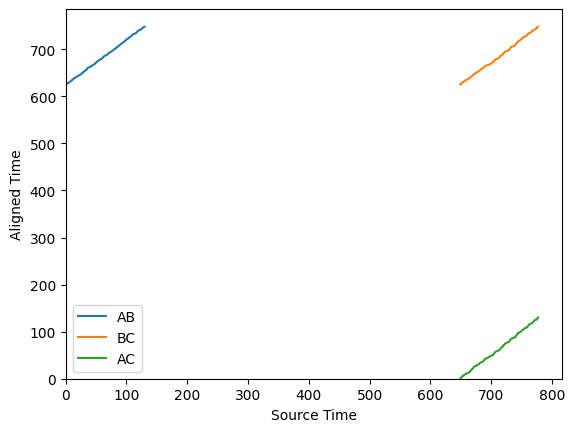

In [89]:
# # import matplotlib.pyplot as plt

# # alignment1 = wp_AB_
# # alignment2 = wp_BC
# # alignment3 = wp_AC

# plt.plot(path[0], path[2], label='AB')
# plt.plot(path[1], path[2], label='BC')
# plt.plot(path[1], path[0], label='AC')
# plt.xlabel('Source Time')
# plt.ylabel('Aligned Time')
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)
# plt.legend()
# plt.show()